In [1]:
import re

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.rcParams["font.family"] = "monospace"

In [2]:
# Training parameters
NUM_DEVICES = 8
BATCH_PER_DEVICE = 1
SEQ_LEN = 64 * 1024
N_EMBD = 768
N_HEAD = 6
N_LAYERS = 12
N = N_EMBD / N_HEAD

# NUM_ITERATIONS = 1825
NUM_ITERATIONS = 1480
VAL_LOSS_EVERY = 125

In [3]:
IMAGES_SAVE_PATH = "."
NORMS_PATTERN = r"median_sv = ([0-9.]+) \| spectral_norm = ([0-9.]+) \| frobenius_norm = ([0-9.]+) \| spectral_norm_est_t2 = ([0-9.]+) \| spectral_norm_est_t4 = ([0-9.]+)"

## Prepare data

### Load

In [4]:
filenames = [
    "dd999b6f-da15-45c6-98f5-2137c673ae9c.txt",
]

labels = [
    "median_sv/spectral_norm",
    "median_sv/frobenius_norm",
    "median_sv/spectral_norm_est_grad2",
    "median_sv/spectral_norm_est_grad4",
]

files = [open(filename, "r").readlines() for filename in filenames]
len(files)

1

### Preprocess data

In [46]:
sv_data_raw: list[list[list[float]]] = [[] for _ in range(len(files))]
for idx, file in enumerate(files):
    for line in file:
        if "G name = 'module._orig_mod.blocks." not in line:
            continue
        try:
            norms_data_ = re.search(NORMS_PATTERN, line)
            norms_data = list(map(lambda x: float(x), norms_data_.groups()))
            sv_data_raw[idx].append([
                norms_data[0] / norms_data[1],
                norms_data[0] / norms_data[2],
                norms_data[0] / norms_data[3],
                norms_data[0] / norms_data[4],
            ])
        except Exception as e:
            print(line, e)

sv_data_raw: np.ndarray = np.array(sv_data_raw).reshape(
    # -1, (NUM_ITERATIONS // VAL_LOSS_EVERY) + 2, N_LAYERS, 2, 2
    -1, NUM_ITERATIONS // VAL_LOSS_EVERY, N_LAYERS, 6, 4
)
sv_data_raw.shape

(1, 11, 12, 6, 4)

## Analysis

In [50]:
sv_data = sv_data_raw.mean((0, -2)).transpose(2, 0, 1)
sv_data.shape

(4, 11, 12)

In [51]:
color_palettes = [
    sns.color_palette("Blues", sv_data.shape[1]),
    sns.color_palette("Greens", sv_data.shape[1]),
    sns.color_palette("Reds", sv_data.shape[1]),
    sns.color_palette("Oranges", sv_data.shape[1]),
]

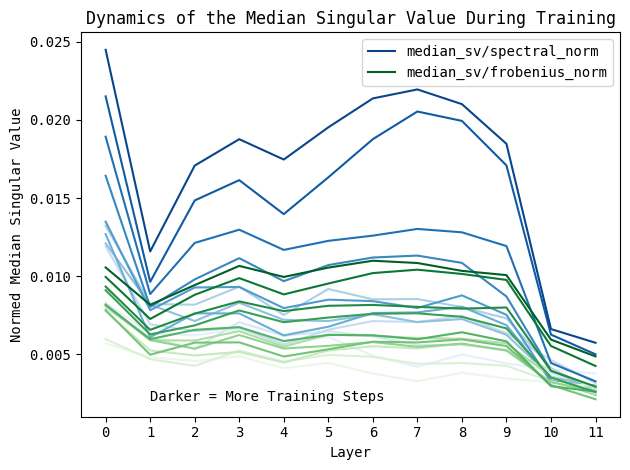

In [52]:
for i in [0, 1]:
    for j in range(sv_data.shape[1]):
        label = None if j < (sv_data.shape[1] - 1) else labels[i]
        sns.lineplot(sv_data[i][j], color=color_palettes[i][j], label=label)

plt.text(1, 0.0020, "Darker = More Training Steps")

plt.xticks(np.linspace(0, 11, 12))
plt.xlabel("Layer")
plt.ylabel("Normed Median Singular Value")
plt.title("Dynamics of the Median Singular Value During Training")
plt.tight_layout()
plt.savefig(f"{IMAGES_SAVE_PATH}/median_sv_dynamics_1.png")

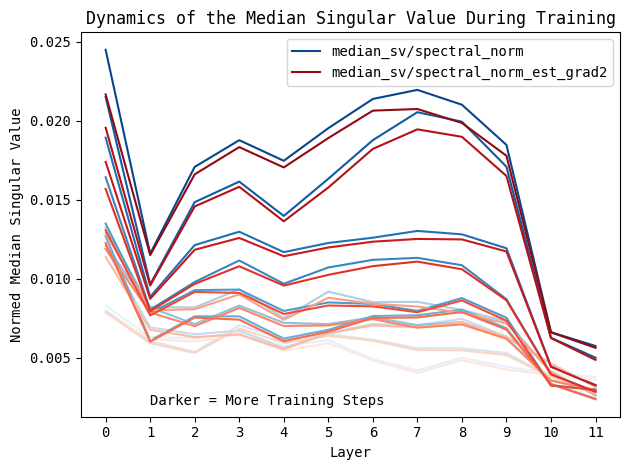

In [53]:
for i in [0, 2]:
    for j in range(sv_data.shape[1]):
        label = None if j < (sv_data.shape[1] - 1) else labels[i]
        sns.lineplot(sv_data[i][j], color=color_palettes[i][j], label=label)

plt.text(1, 0.0020, "Darker = More Training Steps")

plt.xticks(np.linspace(0, 11, 12))
plt.xlabel("Layer")
plt.ylabel("Normed Median Singular Value")
plt.title("Dynamics of the Median Singular Value During Training")
plt.tight_layout()
plt.savefig(f"{IMAGES_SAVE_PATH}/median_sv_dynamics_2.png")

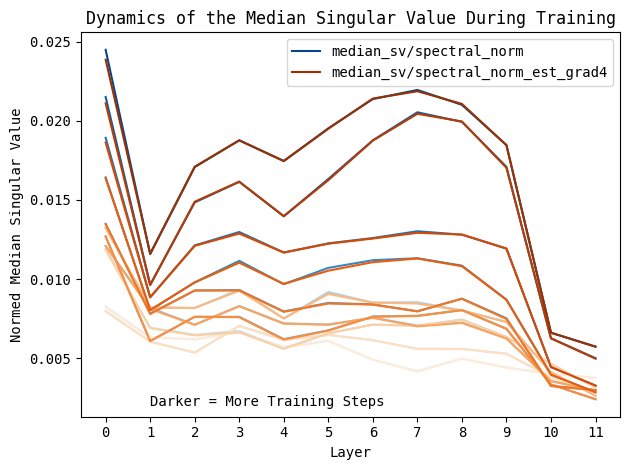

In [54]:
for i in [0, 3]:
    for j in range(sv_data.shape[1]):
        label = None if j < (sv_data.shape[1] - 1) else labels[i]
        sns.lineplot(sv_data[i][j], color=color_palettes[i][j], label=label)

plt.text(1, 0.0020, "Darker = More Training Steps")

plt.xticks(np.linspace(0, 11, 12))
plt.xlabel("Layer")
plt.ylabel("Normed Median Singular Value")
plt.title("Dynamics of the Median Singular Value During Training")
plt.tight_layout()
plt.savefig(f"{IMAGES_SAVE_PATH}/median_sv_dynamics_3.png")